# RNN Classifier

### Direct Deep Learning Comparison

In [1]:
from __future__ import print_function

import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from pandas import DataFrame
from matplotlib import pyplot
import os

Using TensorFlow backend.


In [2]:
infected = os.listdir("input/cell_images/Parasitized/")
uninfected = os.listdir("input/cell_images/Uninfected/")

batch_size = 128
num_classes = 2
epochs = 5
hidden_units = 100

learning_rate = 1e-5
clip_norm = 1

In [3]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("input/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , "RGB")
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(1)
        
    except AttributeError:
        print("")
        
for u in uninfected:
    try:
        
        image = cv2.imread("input/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , "RGB")
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(0)
        
    except AttributeError:
        print("")

In [4]:
cells = np.array(data)
labels = np.array(labels)

np.save("Cells-RNN", cells)
np.save("Labels-RNN", labels)

In [5]:
cells = cells.astype(np.float32)
cells = cells/255

In [6]:
train_x, test_X, train_y, test_Y = train_test_split(cells, labels, test_size = 0.2, random_state = 115)

print("train data shape {}, test data shape {}".format(train_x.shape, test_X.shape))

train data shape (22046, 50, 50, 3), test data shape (5512, 50, 50, 3)


In [7]:
train_x = train_x.reshape(train_x.shape[0], -1, 1)
test_X = test_X.reshape(test_X.shape[0], -1, 1)

print("train data shape {}, test data shape {}".format(train_x.shape, test_X.shape))

num_classes=len(np.unique(labels))

train_y=keras.utils.to_categorical(train_y, num_classes)
test_Y=keras.utils.to_categorical(test_Y, num_classes)

train data shape (22046, 7500, 1), test data shape (5512, 7500, 1)


In [8]:
model = Sequential()
model.add(SimpleRNN(hidden_units, 
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=train_x.shape[1:]))

model.add(Dropout(0.4))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))
          
rmsprop = RMSprop(learning_rate=learning_rate)
adam = Adam(learning_rate=learning_rate, clipnorm=clip_norm)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [10]:
history = model.fit(train_x, train_y, batch_size= batch_size, epochs= epochs, verbose=1, validation_data=(test_X, test_Y))


Train on 22046 samples, validate on 5512 samples
Epoch 1/5
22046/22046 [==============================] - 543s 25ms/step - loss: 0.7176 - accuracy: 0.5333 - val_loss: 0.6829 - val_accuracy: 0.5539
Epoch 2/5
22046/22046 [==============================] - 547s 25ms/step - loss: 0.6777 - accuracy: 0.5773 - val_loss: 0.6628 - val_accuracy: 0.6034
Epoch 3/5
22046/22046 [==============================] - 616s 28ms/step - loss: 0.6705 - accuracy: 0.5933 - val_loss: 0.6739 - val_accuracy: 0.5753
Epoch 4/5
22046/22046 [==============================] - 725s 33ms/step - loss: 0.6701 - accuracy: 0.5951 - val_loss: 0.6842 - val_accuracy: 0.5728
Epoch 5/5
22046/22046 [==============================] - 840s 38ms/step - loss: 0.6654 - accuracy: 0.6069 - val_loss: 0.6730 - val_accuracy: 0.5874


In [14]:
pred_y = model.predict(test_X)

scores = model.evaluate(test_X, test_Y, verbose=0)
print('test score:', scores[0])
print('test accuracy:', scores[1])

test score: 0.6730170108929427
test accuracy: 0.5874455571174622


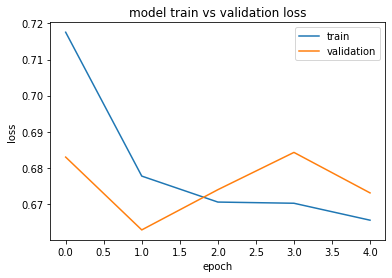

In [15]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [18]:
pred_y = pred_y.argmax(axis=1)
test_Y = test_Y.argmax(axis=1)

confusion = confusion_matrix(test_Y, pred_y)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

AxisError: axis 1 is out of bounds for array of dimension 1

In [19]:
confusion = confusion_matrix(test_Y, pred_y)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[2238  508]
 [1766 1000]]


In [20]:
sensitivity = TP / float(FN + TP)

print(sensitivity)

0.3615328994938539


In [21]:
specificity = TN / (TN + FP)

print(specificity)

0.8150036416605972


In [22]:
pred_y_prob = model.predict_proba(test_X)[:, 1]

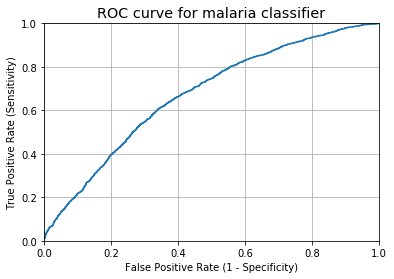

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(test_Y, pred_y_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for malaria classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [25]:
from sklearn import metrics
print(metrics.roc_auc_score(test_Y, pred_y_prob))

0.67194944437686


In [26]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    
evaluate_threshold(0.5)

Sensitivity: 0.3615328994938539
Specificity: 0.8150036416605972


In [28]:
from keras.models import load_model
model.save("RNN_model.h5")